In [1]:
import sys
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

sys.path.append("..")
import geoobb.obb as obb

## Load Data


4000 records returned


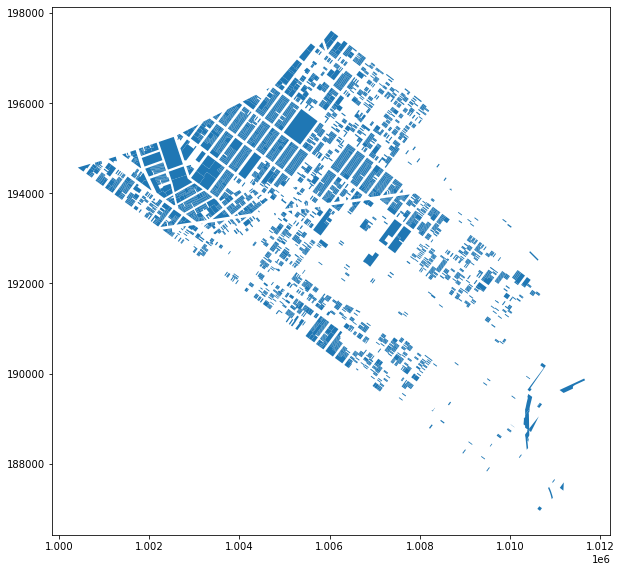

In [2]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson'
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)
gdf.to_crs(epsg=2263, inplace=True)

# the api has a max record limit of 4000
print(f'{len(gdf)} records returned')

gdf.plot(figsize=(10, 10));

## Generate OBBs


### Geometry exterior


In [3]:
%timeit gdf.geometry.map(obb.geom_to_unique_array)

10 loops, best of 3: 187 ms per loop


In [4]:
geo_arrs = gdf.geometry.map(obb.geom_to_unique_array)
%timeit geo_arrs.map(obb.oriented_bounding_box_dimensions)

1 loop, best of 3: 277 ms per loop


In [5]:
geo_arrs = gdf.geometry.map(obb.geom_to_unique_array)
%timeit geo_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 335 ms per loop


### Convex Hull


In [6]:
%timeit gdf.geometry.convex_hull.map(obb.geom_to_array)

10 loops, best of 3: 122 ms per loop


In [7]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
%timeit convex_hull_arrs.map(obb.oriented_bounding_box_dimensions)

1 loop, best of 3: 273 ms per loop


In [8]:
convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
%timeit convex_hull_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 327 ms per loop


Performance: pretty fast for 4,000 geometries! Looks like getting the necessary geoms from the convex hull is faster overall, but doesn't impact performance down the line.


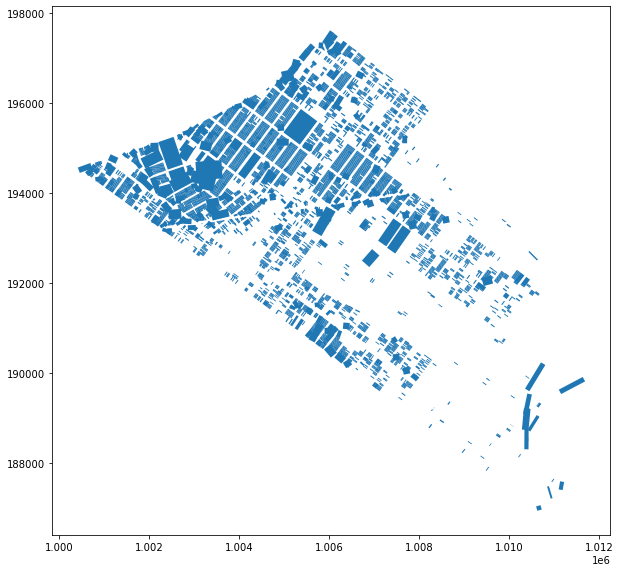

In [9]:
obbs = geo_arrs.apply(obb.oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
obbs_gs.plot(figsize=(10, 10));

## Determine Parcel Orientions


In [10]:
angles = np.array([obb.obb_angle(o) for o in obbs])
abs_angles = np.abs(angles)

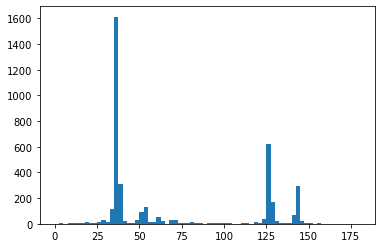

In [11]:
plt.hist(np.degrees(abs_angles), bins=np.arange(0, 182.5, 2.5));

In [12]:
np.median(abs_angles), np.mean(abs_angles)

(0.661001838516494, 1.2309783264133554)

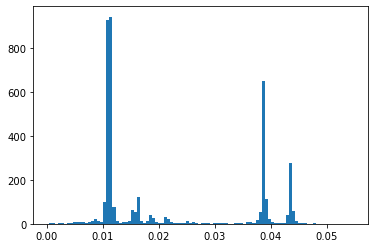

In [13]:
plt.hist(np.radians(abs_angles), bins=100);

## Median Parcel Orientation


In [14]:
med_angle = np.median(abs_angles)

med_angle

0.661001838516494

In [15]:
median_obb_idx = np.argmin(np.abs(angles - med_angle))

median_obb_idx

514

### Transform Geoms


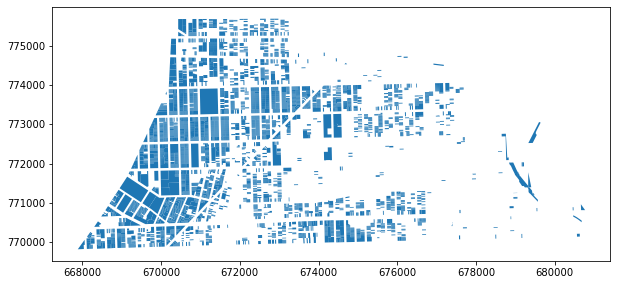

In [46]:
tvect = obb.pca_eigenvectors(geo_arrs[median_obb_idx])

rot_geos = gdf.geometry.map(lambda g: obb.transform_geom_coords(g, tvect))
rot_geos = gpd.GeoDataFrame(rot_geos, crs=gdf.crs)

rot_geos.plot(figsize=(10, 10));

In [17]:
rot_geos.to_file('../data/rot_geos_2.shp')

In [18]:
rot_geos.sindex

rtree.index.Index(bounds=[667881.9366310837, 769824.1658479034, 680772.5109062812, 775683.0895073469], size=4000)

## Test Spatial Join


### Without transformation


In [19]:
xmin, ymin, xmax, ymax = gdf.sindex.bounds
rand_pts = np.random.uniform(low=(xmin, ymin), high=(xmax, ymax), size=(100000, 2))

test_pts = gpd.GeoDataFrame(geometry=[Point(p) for p in rand_pts], crs=gdf.crs)

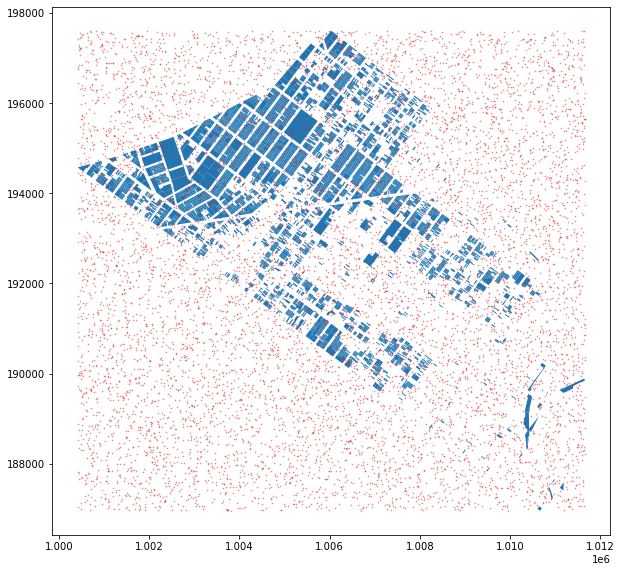

In [20]:
ax = gdf.plot(figsize=(10, 10))
test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [31]:
%timeit gpd.sjoin(test_pts, gdf, op='within')

1 loop, best of 3: 397 ms per loop


In [32]:
regular_join_result = gpd.sjoin(test_pts, gdf, op='within')

In [33]:
len(regular_join_result)

11093

### Rotated


In [74]:
print(tvect)

print(np.ravel(tvect.T))

transformer = np.append(np.ravel(tvect.T), np.zeros(2))
print(transformer)

[[ 0.7874741   0.61634775]
 [-0.61634775  0.7874741 ]]
[ 0.7874741  -0.61634775  0.61634775  0.7874741 ]
[ 0.7874741  -0.61634775  0.61634775  0.7874741   0.          0.        ]


In [65]:
% timeit test_pts.geometry.affine_transform(transformer)

1 loop, best of 3: 1.23 s per loop


In [78]:
# rot_test_pts = test_pts.geometry.map(lambda g: obb.transform_geom_coords(g, tvect))
rot_test_pts = test_pts.geometry.affine_transform(transformer)
rot_test_pts = gpd.GeoDataFrame(rot_test_pts, columns=['geometry'])

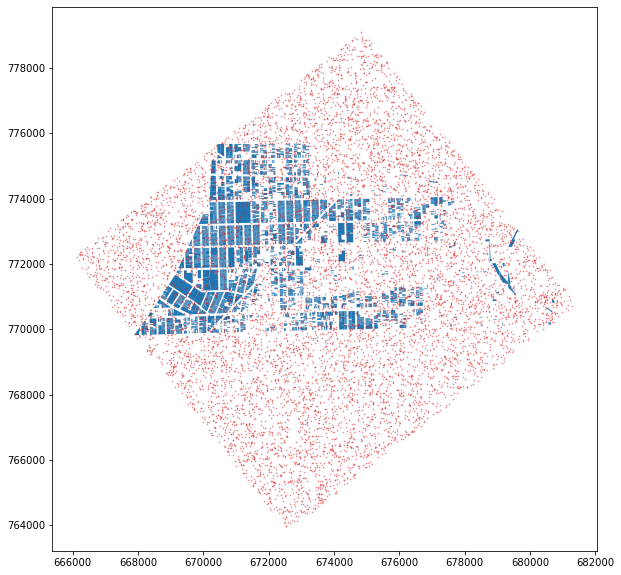

In [79]:
ax = rot_geos.plot(figsize=(10, 10))
rot_test_pts.sample(10000).plot(ax=ax, alpha=0.5, marker='.', color='tab:red', markersize=1.5);

In [81]:
%timeit gpd.sjoin(rot_test_pts, rot_geos, op='within')

1 loop, best of 3: 340 ms per loop


In [82]:
obb_join_result = gpd.sjoin(rot_test_pts, rot_geos, op='within')

In [83]:
len(obb_join_result)

11093

Sadly, impromevement is not worth the added steps


In [84]:
340 / 397

0.8564231738035264